## csv Î°úÎìú Î∞è dataset ÏÑ§Ï†ï

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import cv2
from PIL import Image, ImageFilter
import torch
from torch import nn, optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
device

device(type='cpu')

In [6]:
def load_data(csv_path):
    df = pd.read_csv(csv_path)
    return df

## Ï†ÑÏ≤òÎ¶¨ Í≥ºÏ†ï 

In [9]:
import os
print(os.getcwd())  # ÌòÑÏû¨ ÏûëÏóÖ ÎîîÎ†âÌÜ†Î¶¨ ÌôïÏù∏


/Users/skku_aws19/Desktop/aws_project/pre-project/model


Ï¥ù Ïù¥ÎØ∏ÏßÄ Ïàò: 10


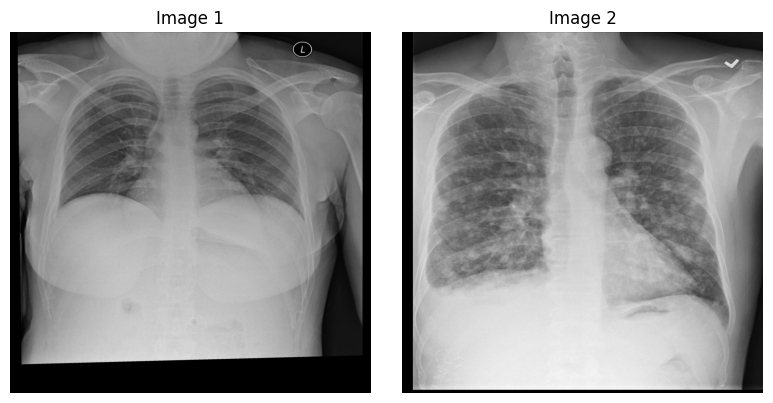

In [13]:
image_paths = sorted(glob.glob('/Users/skku_aws19/Desktop/aws_project/pre-project/data/train/*.jpg'))[:10]
print(f"Ï¥ù Ïù¥ÎØ∏ÏßÄ Ïàò: {len(image_paths)}")
plt.figure(figsize=(8, 4))
for i in range(2):
    img = Image.open(image_paths[i]).convert("RGB")  # ‚Üê Ïó¨Í∏∞ Ï§ëÏöî
    plt.subplot(1, 2, i+1)
    plt.imshow(img)
    plt.title(f"Image {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### grayscale Î≥ÄÌôò

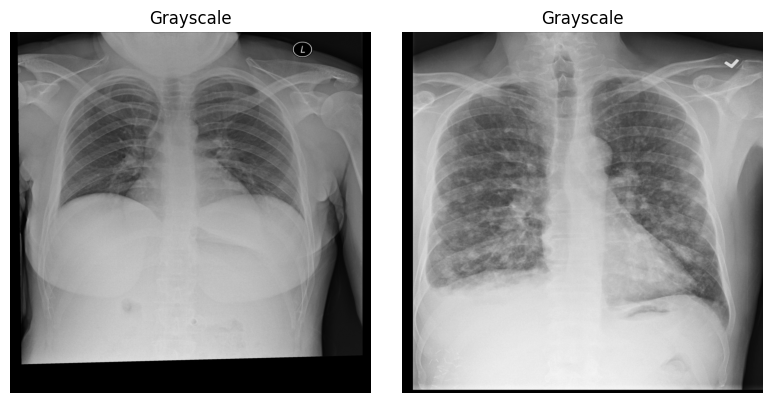

In [11]:
gray_images = []

for path in image_paths:
    img = Image.open(path).convert("L")  # L mode = Grayscale
    gray_images.append(img)

# Í≤∞Í≥º ÌôïÏù∏ (ÏïûÏóêÏÑú 2Ïû•)
plt.figure(figsize=(8, 4))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(gray_images[i], cmap='gray')
    plt.title("Grayscale")
    plt.axis('off')
plt.tight_layout()
plt.show()


### ÌûàÏä§ÌÜ†Í∑∏Îû® ÌèâÌôúÌôî(CLAHE)

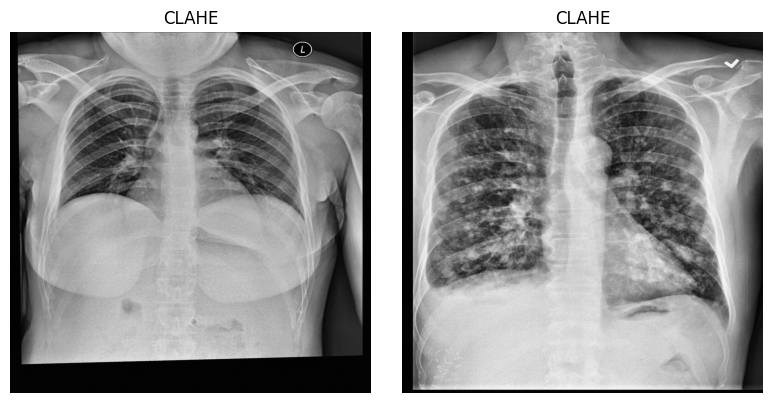

In [14]:
clahe_images = []
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

for img in gray_images:
    np_img = np.array(img)
    equalized = clahe.apply(np_img)
    clahe_images.append(Image.fromarray(equalized))

# Í≤∞Í≥º ÌôïÏù∏
plt.figure(figsize=(8, 4))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(clahe_images[i], cmap='gray')
    plt.title("CLAHE")
    plt.axis('off')
plt.tight_layout()
plt.show()


### Í∞ÄÏö∞ÏãúÏïà ÌïÑÌÑ∞

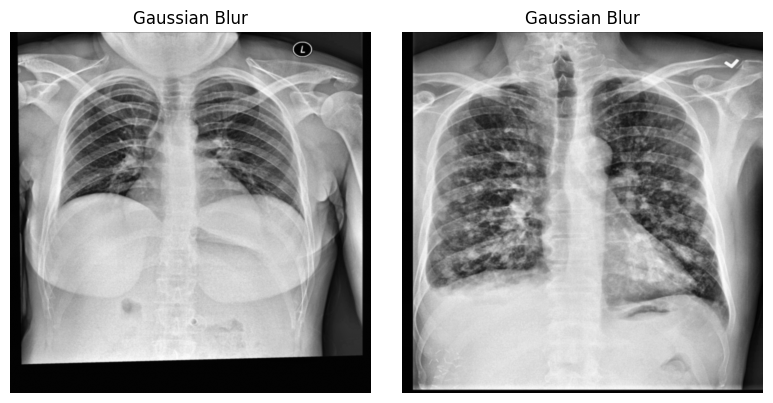

In [15]:
blurred_images = []

for img in clahe_images:
    blurred = img.filter(ImageFilter.GaussianBlur(radius=1.0))
    blurred_images.append(blurred)

# Í≤∞Í≥º ÌôïÏù∏
plt.figure(figsize=(8, 4))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(blurred_images[i], cmap='gray')
    plt.title("Gaussian Blur")
    plt.axis('off')
plt.tight_layout()
plt.show()


### ÏÉ§ÌîÑÎãù ÌïÑÌÑ∞

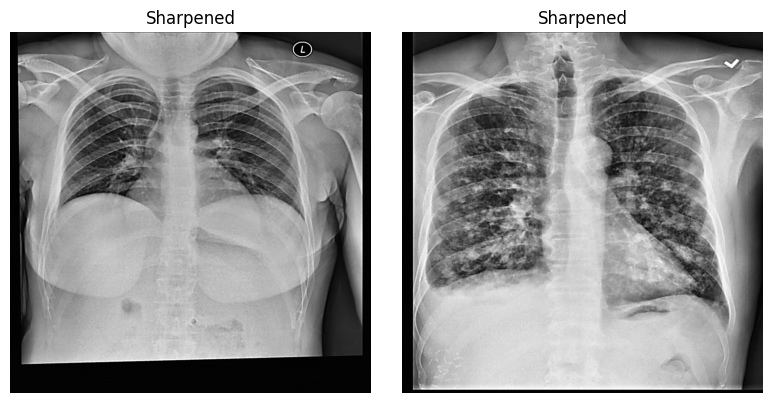

In [16]:
sharpened_images = []

for img in blurred_images:
    sharpened = img.filter(ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3))
    sharpened_images.append(sharpened)

# Í≤∞Í≥º ÌôïÏù∏
plt.figure(figsize=(8, 4))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(sharpened_images[i], cmap='gray')
    plt.title("Sharpened")
    plt.axis('off')
plt.tight_layout()
plt.show()

### rgbÎ°ú Ï†ÑÌôò

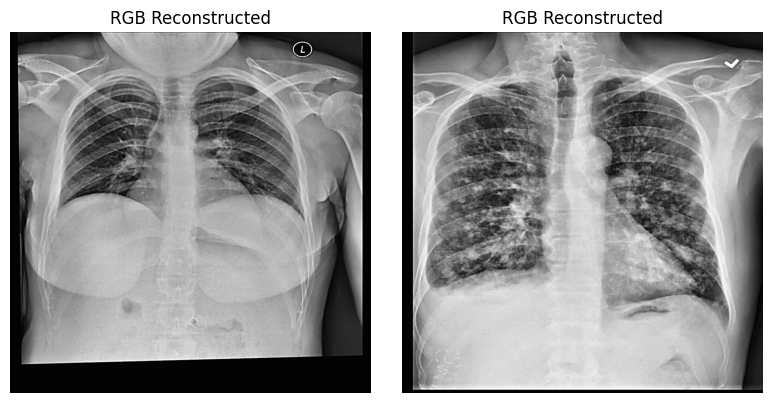

In [17]:
rgb_images = []

for img in sharpened_images:
    rgb_img = Image.merge("RGB", (img, img, img))  # Grayscale 3Ï±ÑÎÑê Î≥µÏÇ¨
    rgb_images.append(rgb_img)

# Í≤∞Í≥º ÌôïÏù∏
plt.figure(figsize=(8, 4))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(rgb_images[i])
    plt.title("RGB Reconstructed")
    plt.axis('off')
plt.tight_layout()
plt.show()


## Ï†ÑÏ≤¥ Ïù¥ÎØ∏ÏßÄ Ï†ÑÏ≤òÎ¶¨ 

In [18]:
# ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄ Ìè¥Îçî Î∞è Ï†ÄÏû• Ìè¥Îçî ÏÑ§Ï†ï
input_dir = '/Users/skku_aws19/Desktop/aws_project/pre-project/data/train'
output_dir = '/Users/skku_aws19/Desktop/aws_project/pre-project/data/train_preprocessed'

os.makedirs(output_dir, exist_ok=True)

# Ïù¥ÎØ∏ÏßÄ Í≤ΩÎ°ú Î¶¨Ïä§Ìä∏
image_paths = sorted(glob.glob(os.path.join(input_dir, '*.jpg')))
print(f"Ï¥ù Ïù¥ÎØ∏ÏßÄ Ïàò: {len(image_paths)}")

Ï¥ù Ïù¥ÎØ∏ÏßÄ Ïàò: 18679


In [ ]:
# CLAHE ÏÑ§Ï†ï
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

for i, path in enumerate(image_paths):
    filename = os.path.basename(path)

    # 1. Load and Grayscale
    img = Image.open(path).convert("L")  # Grayscale

    # 2. CLAHE
    np_img = np.array(img)
    equalized = clahe.apply(np_img)
    img_eq = Image.fromarray(equalized)

    # 3. Gaussian Blur
    img_blur = img_eq.filter(ImageFilter.GaussianBlur(radius=1.0))

    # 4. Sharpening
    img_sharp = img_blur.filter(ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3))

    # 5. Convert to RGB
    img_rgb = Image.merge("RGB", (img_sharp, img_sharp, img_sharp))

    # Ï†ÄÏû•
    save_path = os.path.join(output_dir, filename)
    img_rgb.save(save_path)

    if i % 100 == 0:
        print(f"‚úÖ {i+1}/{len(image_paths)} Ï≤òÎ¶¨ ÏôÑÎ£å: {filename}")
print("üéâ Ï†ÑÏ≤¥ Ïù¥ÎØ∏ÏßÄ Ï†ÑÏ≤òÎ¶¨ Î∞è Ï†ÄÏû• ÏôÑÎ£å!")

In [ ]:
import os
import glob
import cv2
import numpy as np
from PIL import Image, ImageFilter

# Ï≤òÎ¶¨Ìï† ÎåÄÏÉÅ Ìè¥Îçî
target_dirs = {
    '/Users/skku_aws19/Desktop/aws_project/pre-project/data/val': '/Users/skku_aws19/Desktop/aws_project/pre-project/data/val_preprocessed',
    '/Users/skku_aws19/Desktop/aws_project/pre-project/data/test': '/Users/skku_aws19/Desktop/aws_project/pre-project/data/test_preprocessed'
}

# CLAHE ÏÑ§Ï†ï
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

for src_dir, dst_dir in target_dirs.items():
    os.makedirs(dst_dir, exist_ok=True)

    # Ïù¥ÎØ∏ÏßÄ Í≤ΩÎ°ú Î∂àÎü¨Ïò§Í∏∞ (jpg/jpeg/png/JPG)
    image_paths = []
    for ext in ('*.jpg', '*.jpeg', '*.png', '*.JPG'):
        image_paths.extend(glob.glob(os.path.join(src_dir, ext)))

    print(f"üìÇ {src_dir} Ï≤òÎ¶¨ ÏãúÏûë: {len(image_paths)}Í∞ú Ïù¥ÎØ∏ÏßÄ")

    for i, path in enumerate(image_paths):
        filename = os.path.basename(path)

        try:
            # 1. Load and Grayscale
            img = Image.open(path).convert("L")

            # 2. CLAHE
            np_img = np.array(img)
            equalized = clahe.apply(np_img)
            img_eq = Image.fromarray(equalized)

            # 3. Gaussian Blur
            img_blur = img_eq.filter(ImageFilter.GaussianBlur(radius=1.0))

            # 4. Sharpening
            img_sharp = img_blur.filter(ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3))

            # 5. Convert to RGB
            img_rgb = Image.merge("RGB", (img_sharp, img_sharp, img_sharp))

            # Ï†ÄÏû•
            save_path = os.path.join(dst_dir, filename)
            img_rgb.save(save_path)

            if i % 100 == 0:
                print(f"‚úÖ {src_dir} {i+1}/{len(image_paths)} Ï≤òÎ¶¨ Ï§ë: {filename}")

        except Exception as e:
            print(f"‚ö†Ô∏è {filename} Ï≤òÎ¶¨ Ïã§Ìå®: {e}")

    print(f"üéâ {src_dir} Ï†ÑÏ≤òÎ¶¨ ÏôÑÎ£å! Ï†ÄÏû• ÏúÑÏπò ‚Üí {dst_dir}\n")


## Resnet Ï†ÅÏö©

### class Ìè¥Îçî ÎÇòÎàÑÍ∏∞

### train

In [37]:
# ÌÅ¥ÎûòÏä§Î≥Ñ Ìè¥Îçî ÎßåÎì§Í∏∞

import pandas as pd
import os
import shutil

# CSV Î∂àÎü¨Ïò§Í∏∞
df = pd.read_csv('/Users/skku_aws19/Desktop/aws_project/pre-project/data/dataset.csv')

# Ïù¥ÎØ∏ÏßÄÍ∞Ä ÏûàÎäî Í≥≥
src_dir = '/Users/skku_aws19/Desktop/aws_project/pre-project/data/train_preprocessed'

# ÎùºÎ≤® Í∏∞Î∞ò Ìè¥Îçî ÎßåÎì§Í∏∞
for _, row in df.iterrows():
    filename = row['file_name']
    label = str(row['class'])  # ÌòπÏãú Ïà´ÏûêÏùº ÏàòÎèÑ ÏûàÏñ¥ÏÑú str Ï≤òÎ¶¨

    src_path = os.path.join(src_dir, filename)  # ÏõêÎ≥∏ ÌååÏùº Í≤ΩÎ°ú
    dst_dir = os.path.join(src_dir, label)  # ÎùºÎ≤® Ìè¥Îçî Í≤ΩÎ°ú
    dst_path = os.path.join(dst_dir, filename)  # ÎùºÎ≤® Ìè¥Îçî ÎÇ¥ ÌååÏùº Í≤ΩÎ°ú

    if os.path.exists(src_path):  # Ïã§Ï†ú ÌååÏùº ÏûàÏùÑ ÎïåÎßå Ïù¥Îèô
        os.makedirs(dst_dir, exist_ok=True)
        shutil.move(src_path, dst_path)

### val

In [38]:
# ÌÅ¥ÎûòÏä§Î≥Ñ Ìè¥Îçî ÎßåÎì§Í∏∞

import pandas as pd
import os
import shutil

# CSV Î∂àÎü¨Ïò§Í∏∞
df = pd.read_csv('/Users/skku_aws19/Desktop/aws_project/pre-project/data/dataset.csv')

# Ïù¥ÎØ∏ÏßÄÍ∞Ä ÏûàÎäî Í≥≥
src_dir = '/Users/skku_aws19/Desktop/aws_project/pre-project/data/val_preprocessed'

# ÎùºÎ≤® Í∏∞Î∞ò Ìè¥Îçî ÎßåÎì§Í∏∞
for _, row in df.iterrows():
    filename = row['file_name']
    label = str(row['class'])  # ÌòπÏãú Ïà´ÏûêÏùº ÏàòÎèÑ ÏûàÏñ¥ÏÑú str Ï≤òÎ¶¨

    src_path = os.path.join(src_dir, filename)  # ÏõêÎ≥∏ ÌååÏùº Í≤ΩÎ°ú
    dst_dir = os.path.join(src_dir, label)  # ÎùºÎ≤® Ìè¥Îçî Í≤ΩÎ°ú
    dst_path = os.path.join(dst_dir, filename)  # ÎùºÎ≤® Ìè¥Îçî ÎÇ¥ ÌååÏùº Í≤ΩÎ°ú

    if os.path.exists(src_path):  # Ïã§Ï†ú ÌååÏùº ÏûàÏùÑ ÎïåÎßå Ïù¥Îèô
        os.makedirs(dst_dir, exist_ok=True)
        shutil.move(src_path, dst_path)

### test

In [39]:
# ÌÅ¥ÎûòÏä§Î≥Ñ Ìè¥Îçî ÎßåÎì§Í∏∞

import pandas as pd
import os
import shutil

# CSV Î∂àÎü¨Ïò§Í∏∞
df = pd.read_csv('/Users/skku_aws19/Desktop/aws_project/pre-project/data/dataset.csv')

# Ïù¥ÎØ∏ÏßÄÍ∞Ä ÏûàÎäî Í≥≥
src_dir = '/Users/skku_aws19/Desktop/aws_project/pre-project/data/test_preprocessed'

# ÎùºÎ≤® Í∏∞Î∞ò Ìè¥Îçî ÎßåÎì§Í∏∞
for _, row in df.iterrows():
    filename = row['file_name']
    label = str(row['class'])  # ÌòπÏãú Ïà´ÏûêÏùº ÏàòÎèÑ ÏûàÏñ¥ÏÑú str Ï≤òÎ¶¨

    src_path = os.path.join(src_dir, filename)  # ÏõêÎ≥∏ ÌååÏùº Í≤ΩÎ°ú
    dst_dir = os.path.join(src_dir, label)  # ÎùºÎ≤® Ìè¥Îçî Í≤ΩÎ°ú
    dst_path = os.path.join(dst_dir, filename)  # ÎùºÎ≤® Ìè¥Îçî ÎÇ¥ ÌååÏùº Í≤ΩÎ°ú

    if os.path.exists(src_path):  # Ïã§Ï†ú ÌååÏùº ÏûàÏùÑ ÎïåÎßå Ïù¥Îèô
        os.makedirs(dst_dir, exist_ok=True)
        shutil.move(src_path, dst_path)

### Dataloader

### transform

In [12]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet ÏûÖÎ†• ÌÅ¨Í∏∞
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [47]:
from torchvision import datasets, transforms  
from torch.utils.data import DataLoader

train_dataset = datasets.ImageFolder('/Users/skku_aws19/Desktop/aws_project/pre-project/data/train_preprocessed', transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = datasets.ImageFolder('/Users/skku_aws19/Desktop/aws_project/pre-project/data/val_preprocessed', transform=data_transforms)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataset = datasets.ImageFolder('/Users/skku_aws19/Desktop/aws_project/pre-project/data/test_preprocessed', transform=data_transforms)
test_loader = DataLoader(test_dataset,batch_size=32, shuffle=False)

## Model

In [22]:
model = models.resnet50(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, 3)  # 3-class classification
model = model.to(device)

### ÌïôÏäµ Î£®ÌîÑ

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

# üéØ TensorBoard ÏÑ§Ï†ï
tensorboard --logdir= ./runs/pneumonia_20250710

writer = SummaryWriter(log_dir=log_dir)

# Î™®Îç∏ Íµ¨Ï°∞ ÏãúÍ∞ÅÌôî (1ÌöåÎßå)
example_input = torch.randn(1, 3, 224, 224).to(device)
writer.add_graph(model, example_input)

# ÏòµÌã∞ÎßàÏù¥Ï†Ä Ï†ïÎ≥¥ Í∏∞Î°ù
writer.add_text("Model", model._get_name())
writer.add_text("Loss Function", criterion._get_name())
writer.add_text("Device", str(device))
opt_params = optimizer.__getstate__()['defaults']
opt_text = '\n'.join([f"{k}: {v}" for k, v in opt_params.items()])
writer.add_text("Optimizer Parameters", opt_text)

# ‚úÖ ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞
num_epochs = 20
patience = 5
best_val_acc = 0.0
patience_counter = 0

# üîÅ ÌïôÏäµ Î£®ÌîÑ
for epoch in range(num_epochs):
    print(f"\nüìò Epoch [{epoch+1}/{num_epochs}]")
    
    model.train()
    running_loss, running_correct, total = 0.0, 0, 0

    train_loop = tqdm(train_loader, desc="Training", leave=False)
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        running_correct += predicted.eq(labels).sum().item()

        train_loop.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "Acc": f"{100. * running_correct / total:.2f}%"
        })

    train_acc = 100. * running_correct / total
    train_loss = running_loss / len(train_loader)

    # ‚úÖ Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    val_loop = tqdm(val_loader, desc="Validating", leave=False)
    with torch.no_grad():
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

            val_loop.set_postfix({
                "Loss": f"{loss.item():.4f}",
                "Acc": f"{100. * val_correct / val_total:.2f}%"
            })

    val_acc = 100. * val_correct / val_total
    val_loss /= len(val_loader)

    print(f"‚úÖ Epoch {epoch+1} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    # ‚úÖ TensorBoardÏóê Í∏∞Î°ù
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/val", val_loss, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    writer.add_scalar("Accuracy/val", val_acc, epoch)

    # ‚úÖ Early Stopping & Save Best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_model_augmented.pth")
        print(f"üíæ Î™®Îç∏ Ï†ÄÏû•Îê® (val acc: {val_acc:.2f}%)")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"üõë Early stopping at epoch {epoch+1}")
            break

    # ‚úÖ Scheduler ÏóÖÎç∞Ïù¥Ìä∏
    scheduler.step(val_acc)

writer.close()
print("üèÅ ÌïôÏäµ ÏôÑÎ£å")

#tensorboard --logdir=./runs  ---> ÌÑ∞ÎØ∏ÎÑêÏóê Ïã§Ìñâ


üìò Epoch [1/20]


‚úÖ Epoch 1 | Train Loss: 0.6201, Acc: 72.20% | Val Loss: 0.6837, Acc: 72.55%
üíæ Î™®Îç∏ Ï†ÄÏû•Îê® (val acc: 72.55%)

üìò Epoch [2/20]


‚úÖ Epoch 2 | Train Loss: 0.5864, Acc: 74.23% | Val Loss: 0.6905, Acc: 73.53%
üíæ Î™®Îç∏ Ï†ÄÏû•Îê® (val acc: 73.53%)

üìò Epoch [3/20]


‚úÖ Epoch 3 | Train Loss: 0.5650, Acc: 74.84% | Val Loss: 0.6819, Acc: 72.92%

üìò Epoch [4/20]


‚úÖ Epoch 4 | Train Loss: 0.5494, Acc: 76.11% | Val Loss: 0.7464, Acc: 71.42%

üìò Epoch [5/20]


‚úÖ Epoch 5 | Train Loss: 0.5346, Acc: 76.84% | Val Loss: 0.6975, Acc: 72.66%

üìò Epoch [6/20]


‚úÖ Epoch 6 | Train Loss: 0.5133, Acc: 77.54% | Val Loss: 0.7205, Acc: 72.15%

üìò Epoch [7/20]


‚úÖ Epoch 7 | Train Loss: 0.4895, Acc: 78.82% | Val Loss: 0.7696, Acc: 71.32%
üõë Early stopping at epoch 7
üèÅ ÌïôÏäµ ÏôÑÎ£å


## Test 

In [ ]:
import torch
from torchvision import models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Î™®Îç∏ Íµ¨Ï°∞ ÎèôÏùºÌïòÍ≤å Î°úÎìú
model = models.resnet50(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, 3)  # ÌÅ¥ÎûòÏä§ Ïàò ÎèôÏùºÌï¥Ïïº Ìï®
model.load_state_dict(torch.load("best_model_augmented.pth"))
model = model.to(device)
model.eval()

# Ï†ïÌôïÎèÑ Í≥ÑÏÇ∞
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_acc = 100. * correct / total
print(f"üß™ ÌÖåÏä§Ìä∏ Ï†ïÌôïÎèÑ: {test_acc:.2f}%")

### ÏÑ±Îä• ÏßÄÌëú Ï†ÄÏû•

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# CPU Í∞ïÏ†ú ÏÇ¨Ïö©
device = torch.device("cpu")
model.to(device)
model.eval()

# ÏòàÏ∏° ÏàòÏßë
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        all_labels.append(labels.cpu())
        all_probs.append(probs.cpu())

# Í≤∞Í≥º Î≥ÄÌôò
y_true = torch.cat(all_labels).numpy()
y_score = torch.cat(all_probs).numpy()
y_pred = np.argmax(y_score, axis=1)

# confusion matrix Î∞è report
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, output_dict=True)

# ROC
n_classes = y_score.shape[1]
class_names = ['normal', 'pneumonia', 'not_normal']
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Í∑∏Î¶º Í∑∏Î¶¨Í∏∞
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=class_names, yticklabels=class_names)
axes[0, 0].set_title("Confusion Matrix")
axes[0, 0].set_xlabel("Predicted")
axes[0, 0].set_ylabel("True")

# 2. Precision per Class
precisions = [report[str(i)]['precision'] for i in range(n_classes)]
axes[0, 1].bar(class_names, precisions, color='skyblue')
axes[0, 1].set_title("Precision per Class")
axes[0, 1].set_ylim([0, 1])
axes[0, 1].set_ylabel("Precision")

# 3. ROC Curve
colors = ['red', 'green', 'blue']
for i in range(n_classes):
    axes[1, 0].plot(fpr[i], tpr[i], color=colors[i], lw=2,
                    label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
axes[1, 0].plot([0, 1], [0, 1], 'k--', lw=1)
axes[1, 0].set_title("ROC Curve")
axes[1, 0].set_xlabel("False Positive Rate")
axes[1, 0].set_ylabel("True Positive Rate")
axes[1, 0].legend(loc='lower right')
axes[1, 0].grid(True)

# 4. Confidence Histogram
confidences = np.max(y_score, axis=1)
axes[1, 1].hist(confidences, bins=20, color='orange', edgecolor='black')
axes[1, 1].set_title("Prediction Confidence Histogram")
axes[1, 1].set_xlabel("Confidence")
axes[1, 1].set_ylabel("Frequency")

# Ï†ÄÏû•
plt.tight_layout()
output_path = "/mnt/data/model_dashboard_real_output.png"
plt.savefig(output_path)
plt.close()

print("‚úÖ ÏãúÍ∞ÅÌôî ÏôÑÎ£å:", output_path)


